In [1]:
# 03_model_tuning.ipynb
# Tune hyperparameters of best performing models from 02_baselines to improve performance

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [39]:
# sklearn tools for preprocessing, model building, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import warnings
warnings.filterwarnings("ignore")  # suppress sklearn/XGBoost warnings for clarity

In [20]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [6]:
# copy csv from drive into colab temp storage
!cp "/content/drive/MyDrive/cardio-ml-project/cardio_train.csv" "/content/cardio_train.csv"

# load dataset
import pandas as pd
cardio = pd.read_csv("/content/cardio_train.csv", sep=";")
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
# Feature Engineering

# BMI for cardio dataset
cardio['bmi'] = cardio['weight'] / (cardio['height']/100)**2

# blood pressure difference
cardio['bp_diff'] = cardio['ap_hi'] - cardio['ap_lo']

# convert age from days to years
cardio['age_years'] = (cardio['age'] / 365).astype(int)

In [8]:
# Features (X) and target (y)

X = cardio[['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_diff', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']]
y = cardio['cardio'] # 1 = disease, 0 = no disease

In [10]:
# Train-test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 80% train, 20% test

In [12]:
# Scale numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (56000, 13)  Test size: (14000, 13)


In [32]:
# Paths and results/models setup

results_path = "/content/drive/MyDrive/cardio-ml-project/results"
models_path = "/content/drive/MyDrive/cardio-ml-project/models"

os.makedirs(results_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [33]:
# load existing results or create new dataframe
try:
    tuned_results_df = pd.read_csv(f"{results_path}/tuned_results.csv")
    print("Loaded existing tuning results.")
except FileNotFoundError:
    tuned_results_df = pd.DataFrame(
        columns=["Model", "Best Params", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
    )
    print("No tuning results found, starting fresh.")

try:
    tuned_results_df = pd.read_csv(f"{results_path}/tuning_results.csv")
except FileNotFoundError:
    tuned_results_df = pd.DataFrame(columns=["Model", "Best Params", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"])

No tuning results found, starting fresh.


In [35]:
# Models

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Neural Net (MLP)": MLPClassifier(random_state=42)
}

In [42]:
# Define parameter grids (reduced a bit)

param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10], "solver": ["liblinear"]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 10]},
    "Decision Tree": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "KNN": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]},
    "SVM": {"C": [0.1, 1], "kernel": ["rbf"]},  # single kernel
    "XGBoost": {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.05, 0.1]},
    "Extra Trees": {"n_estimators": [100, 200], "max_depth": [None, 10]},
    "Neural Net (MLP)": {"hidden_layer_sizes": [(50,)], "activation": ["relu"], "solver": ["adam"], "alpha": [0.001], "max_iter": [50]}  # smaller & fewer iterations
}

In [45]:
# Tune and save function

# Temporarily disable SVM probability during tuning
models["SVM"].probability = False

for name, model in models.items():
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Re-enable probability for SVM if needed for ROC-AUC
    if name == "SVM":
        best_model.probability = True
        best_model.fit(X_train, y_train)

    # Retrain MLP with a few more iterations if desired
    if name == "Neural Net (MLP)":
        best_model.set_params(max_iter=100)
        best_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Metrics
    row = {
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    # Append & save results
    tuned_results_df = pd.concat([tuned_results_df, pd.DataFrame([row])], ignore_index=True)
    tuned_results_df.to_csv(f"{results_path}/tuned_results.csv", index=False)

    # Save model
    joblib.dump(best_model, f"{models_path}/{name.replace(' ', '_')}_tuned.pkl")
    print(f"{name} tuning complete and saved.")

print("\n All models tuned and saved. Check 'tuned_results.csv' for metrics.")


 Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression tuning complete and saved.

 Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Random Forest tuning complete and saved.

 Tuning Decision Tree...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Decision Tree tuning complete and saved.

 Tuning KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
KNN tuning complete and saved.

 Tuning SVM...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM tuning complete and saved.

 Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost tuning complete and saved.

 Tuning Extra Trees...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Extra Trees tuning complete and saved.

 Tuning Neural Net (MLP)...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Neural Net (MLP) tuning complete and saved.

 All models tuned and sa

In [46]:
# load tuned results

tuned_results_df = pd.read_csv(f"{results_path}/tuned_results.csv")
tuned_results_df.sort_values(by="ROC-AUC", ascending=False, inplace=True)
tuned_results_df

,Model,Best Params,Accuracy,Precision,Recall,F1,ROC-AUC
16,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.734214,0.753837,0.695111,0.723284,0.801040
6,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.730857,0.757006,0.679531,0.716180,0.797870
2,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.730857,0.757006,0.679531,0.716180,0.797870
12,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.730857,0.757006,0.679531,0.716180,0.797870
18,Neural Net (MLP),"{'activation': 'relu', 'alpha': 0.001, 'hidden...",0.730643,0.756319,0.680103,0.716189,0.795723
15,SVM,"{'C': 1, 'kernel': 'rbf'}",0.724786,0.740254,0.692110,0.715373,0.782796
3,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.724714,0.731643,0.709262,0.720279,0.779665
7,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.724714,0.731643,0.709262,0.720279,0.779665
13,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.724714,0.731643,0.709262,0.720279,0.779665
5,Logistic Regression,"{'C': 1, 'solver': 'liblinear'}",0.714143,0.731734,0.675672,0.702586,0.778152


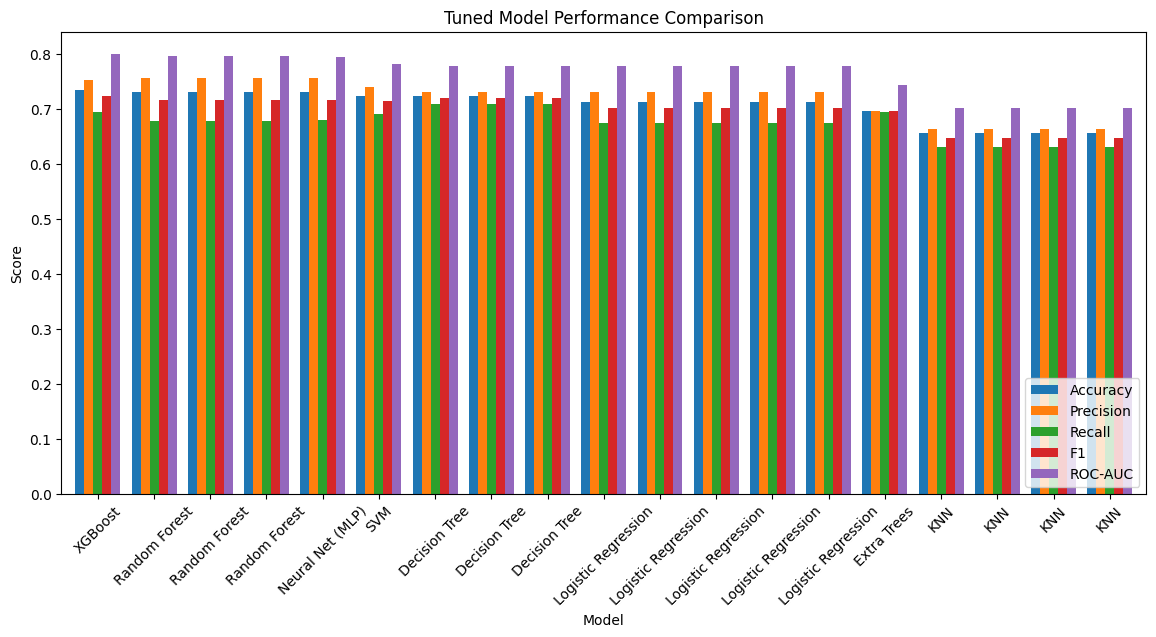

In [47]:
# plot metrics for models

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

tuned_results_df.plot(
    x="Model",
    y=metrics,
    kind="bar",
    figsize=(14,6),
    width=0.8
)
plt.title("Tuned Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

Top 5 Models by ROC-AUC:
               Model                                        Best Params  \
16           XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
6      Random Forest             {'max_depth': 10, 'n_estimators': 200}   
18  Neural Net (MLP)  {'activation': 'relu', 'alpha': 0.001, 'hidden...   
15               SVM                          {'C': 1, 'kernel': 'rbf'}   
3      Decision Tree          {'max_depth': 10, 'min_samples_split': 2}   

    Accuracy  Precision    Recall        F1   ROC-AUC  
16  0.734214   0.753837  0.695111  0.723284  0.801040  
6   0.730857   0.757006  0.679531  0.716180  0.797870  
18  0.730643   0.756319  0.680103  0.716189  0.795723  
15  0.724786   0.740254  0.692110  0.715373  0.782796  
3   0.724714   0.731643  0.709262  0.720279  0.779665  


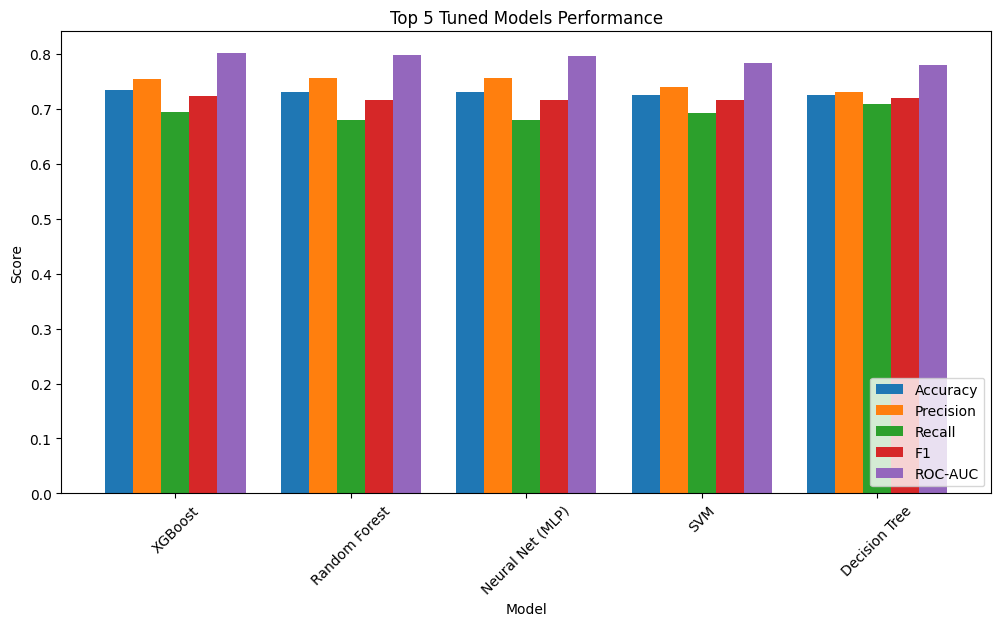

In [50]:
# remove duplicates
tuned_results_df_unique = tuned_results_df.drop_duplicates(subset=["Model"], keep="first")

# sort by ROC-AUC descending
tuned_results_df_unique.sort_values(by="ROC-AUC", ascending=False, inplace=True)

# show top 5 models
top_models = tuned_results_df_unique.head(5)
print("Top 5 Models by ROC-AUC:")
print(top_models)

# plot top 5 models metrics
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
top_models.plot(
    x="Model",
    y=metrics,
    kind="bar",
    figsize=(12,6),
    width=0.8
)
plt.title("Top 5 Tuned Models Performance")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

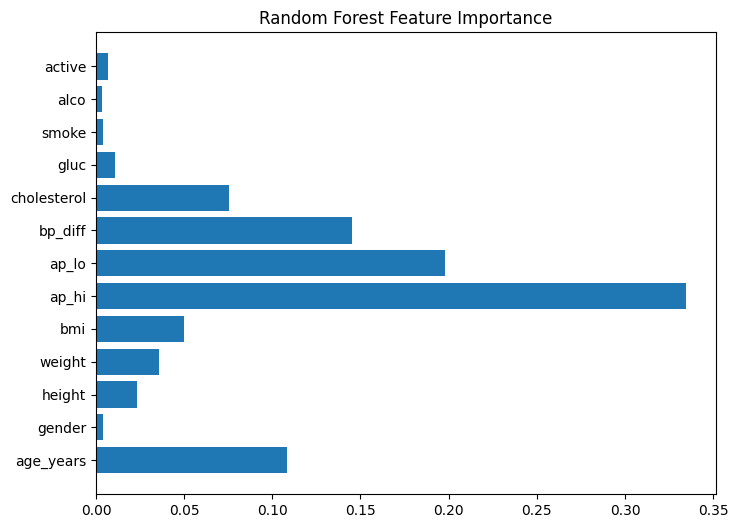

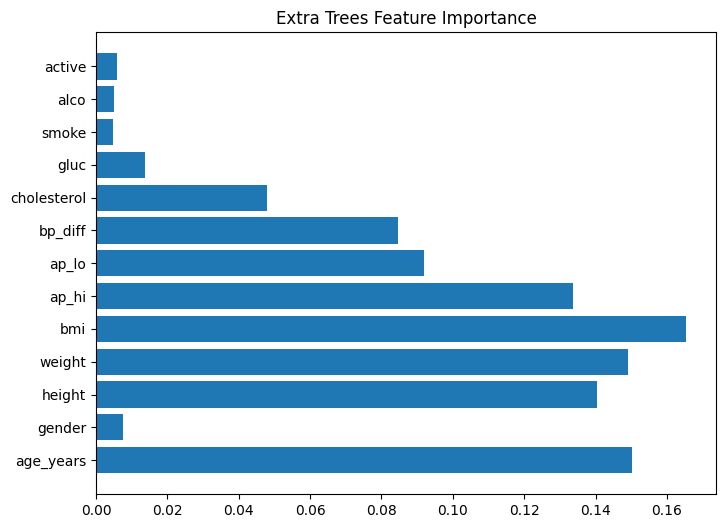

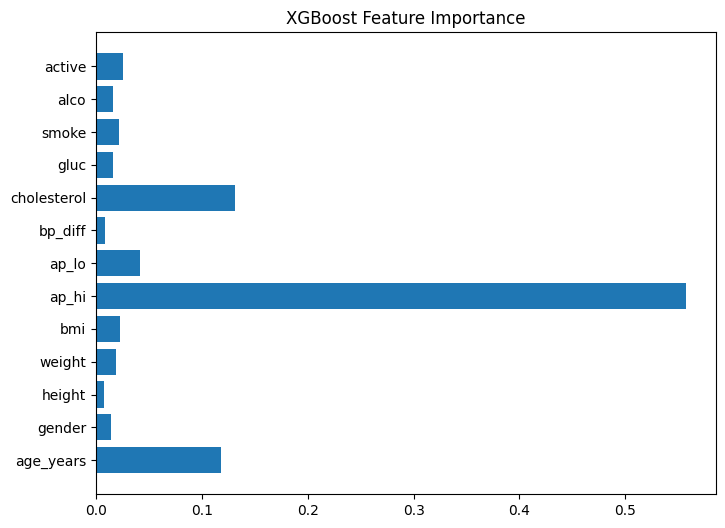

In [53]:
# Feature importance for tree-based models

tree_models = ["Random Forest", "Extra Trees", "XGBoost"]

# label feature names
feature_names = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'bp_diff', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

for tm in tree_models:
    try:
        model_file = f"{models_path}/{tm.replace(' ', '_')}_tuned.pkl"
        model = joblib.load(model_file)
        importances = model.feature_importances_

        plt.figure(figsize=(8,6))
        plt.barh(feature_names, importances)
        plt.title(f"{tm} Feature Importance")
        plt.show()
    except Exception as e:
        print(f"Could not plot feature importance for {tm}: {e}")